# **Machine Learning using Grammatical Evolution**
### Classification of mammogram segments as containing or not containing suspicious growth. 
Ranya El-Hwigi 18227449

### ***Clone GRAPE repository***

In [2]:
import os.path

In [3]:
PATH = '/users/ranyahwigi/desktop/FYP/grape'
if os.path.exists(PATH):
    print('grape directory already exists')
else:
    !git clone https://github.com/UL-BDS/grape.git 
    print('Cloning grape in your Drive')

%cd /users/ranyahwigi/desktop/FYP/grape/

grape directory already exists
/Users/ranyahwigi/Desktop/FYP/grape


In [4]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

### ***Importing libraries***

In [5]:
!pip install deap
!pip install numpy
!pip install -U imbalanced-learn

import algorithms
from ponyge2_adapted_files import Grammar, ge
from functions import add, sub, mul, pdiv, neg

import numpy as np
from os import path
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from deap import creator, base, tools
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import math

### ***Preparing Data***

**Loading dataset**

In [7]:
# loading in the dataset into a pandas dataframe from GitHub
data = pd.read_csv('https://media.githubusercontent.com/media/relhwigi/GE_GRAPE_Mammogram_Classification/main/data/haralick02_250K.csv')

**Extracting information on the data**

*Size of dataset*

In [8]:
# number of rows in dataset
number_of_samples = data['PatientID'].count()

**Dropping columns from dataset**

In [9]:
data.drop(['PatientID', 'StudyID', 'PatientAge', 'ImgID', 'View', 'SegmentPosition'], axis=1, inplace=True)

**Number of columns remaining**

In [10]:
final_number_of_columns = len(data.columns)

**Train and test split**

In [11]:
X = np.zeros([number_of_samples, final_number_of_columns-1], dtype=float)
Y = np.zeros([number_of_samples,], dtype=int)

for i in range(number_of_samples):
    for j in range(final_number_of_columns-1):
        X[i,j] = data['x'+ str(j)].iloc[i]

for i in range(number_of_samples):
    Y[i] = data['Label'].iloc[i]

oversample = SMOTE()
X, Y = oversample.fit_resample(X, Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

print('Training (X,Y):\t', X_train.shape, Y_train.shape)
print('Test (X,Y):\t', X_test.shape, Y_test.shape)

X_train = np.transpose(X_train)
X_test = np.transpose(X_test)

Training (X,Y):	 (33625, 104) (33625,)
Test (X,Y):	 (14411, 104) (14411,)


**Check grammar file**

In [19]:
f = open("../GE_GRAPE_Mammogram_Classification/grammar.bnf", "r")
print(f.read())
f.close() 

<e> ::= add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|add(<e>,<e>)|sub(<e>,<e>)|pdiv(<e>,<e>)|mul(<e>,<e>)|neg(<e>)|

**Setup grammar**

In [20]:
BNF_GRAMMAR = Grammar("../GE_GRAPE_Mammogram_Classification/grammar.bnf")

### ***Fitness Function***

In [21]:
def fitness_eval(individual, points):
  x= points[0]
  Y= points[1]

  if individual.invalid==True:
    return np.NaN,

  try:
    pred= eval(individual.phenotype)
  except (FloatingPointError, ZeroDivisionError, OverflowError, MemoryError):
    return np.NaN,
  assert np.isrealobj(pred)

  try:
    Y_class= [1 if pred[i] > 0 else 0 for i in range(len(Y))]
  except (IndexError, TypeError):
    return np.NaN,

  # TP -> True Positive, FP -> False Posititve, TN -> True Negative, FN -> False Negtaive
  # 0 -> negative, 1 -> positive

  TP, FN, TN, FP = 0, 0, 0, 0

  for x, y in zip(Y, Y_class):
    if x == 1:
      if y == 1:
        TP = TP + 1
      else:
        FN = FN + 1
    elif x == 0:
      if y == 0:
        TN = TN + 1
      else:
        FP = FP + 1

  if FN == 0 and TN == 0:
    return np.NaN,
  elif FP == 0 and TP == 0:
    return np.NaN,
  else:
    # Calculating Accuracy
    numerator = (TP+TN)
    denominator = (TP+TN+FP+FN)
    fitness = numerator / denominator

  return fitness,

### ***Grammatical Evolution***

**Setting GE parameters**

In [22]:
POPULATION_SIZE = 200
MAX_GENERATIONS = 100
P_CROSSOVER = 0.8
P_MUTATION = 0.01
ELITE_SIZE = round(0.01*POPULATION_SIZE)
HALL_OF_FAME_SIZE = 1
MAX_INIT_TREE_DEPTH = 13
MIN_INIT_TREE_DEPTH = 3
MAX_TREE_DEPTH = 23
MAX_WRAPS = 0
CODON_SIZE = 320

**Creating DEAP toolbox**

In [23]:
toolbox = base.Toolbox()

creator.create("FitnessMax", base.Fitness, weights=(1.0,))

creator.create('Individual', ge.Individual, fitness=creator.FitnessMax)

toolbox.register("populationCreator", ge.initialisation_PI_Grow, creator.Individual) 

toolbox.register("evaluate", fitness_eval)

toolbox.register("select", ge.selTournament, tournsize=5)

toolbox.register("mate", ge.crossover_onepoint)

toolbox.register("mutate", ge.mutation_int_flip_per_codon)

**Main function**

In [24]:
population = toolbox.populationCreator(size=POPULATION_SIZE, 
                                        bnf_grammar=BNF_GRAMMAR, 
                                        min_init_tree_depth=MIN_INIT_TREE_DEPTH,
                                        max_init_tree_depth=MAX_INIT_TREE_DEPTH,
                                        max_tree_depth=MAX_TREE_DEPTH, 
                                        max_wraps=MAX_WRAPS,
                                        codon_size=CODON_SIZE
                                        )

hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.nanmean)
stats.register("std", np.nanstd)
stats.register("min", np.nanmin)
stats.register("max", np.nanmax)

population, logbook = algorithms.ge_eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                                        ngen=MAX_GENERATIONS, elite_size=ELITE_SIZE,
                                                        bnf_grammar=BNF_GRAMMAR, codon_size=CODON_SIZE, 
                                                        max_tree_depth=MAX_TREE_DEPTH, max_wraps=MAX_WRAPS,
                                                        points_train=[X_train, Y_train], 
                                                        points_test=[X_test, Y_test], 
                                                        stats=stats, halloffame=hof, verbose=True)

gen	invalid	avg     	std      	min     	max     	fitness_test	best_ind_length	avg_length	max_length	selection_time	generation_time
0  	0      	0.499064	0.0318488	0.368981	0.596729	0.362917    	13             	123.205   	724       	0             	4.62144        
1  	93     	0.504213	0.0295938	0.368981	0.592   	0.596558    	83             	123.17    	803       	0.00115609    	2.66769        
2  	26     	0.508806	0.0296912	0.368981	0.589204	0.596558    	83             	99.32     	480       	0.00114202    	3.3484         
3  	23     	0.510066	0.0299517	0.368981	0.573264	0.596558    	83             	103.46    	468       	0.00118136    	3.23849        
4  	9      	0.509175	0.0318772	0.368981	0.575703	0.596558    	83             	116.385   	471       	0.00117779    	3.3214         
5  	10     	0.512647	0.0346457	0.368981	0.605888	0.607453    	165            	114.865   	471       	0.00114918    	3.36326        
6  	8      	0.514992	0.0376642	0.368981	0.605888	0.607453    	165            	108.8

62 	0      	0.550557	0.0515537	0.368595	0.639316	0.647491    	54             	79.505    	260       	0.00113201    	3.66806        
63 	1      	0.557267	0.0477939	0.368595	0.639316	0.647491    	54             	80.725    	260       	0.00113988    	3.53346        
64 	2      	0.555558	0.052361 	0.368595	0.637145	0.647491    	54             	77.025    	260       	0.00211191    	3.53579        
65 	1      	0.552246	0.0547011	0.368595	0.639316	0.647491    	54             	75.235    	231       	0.00123286    	3.45493        
66 	0      	0.553293	0.0486266	0.368595	0.639316	0.647491    	54             	79.23     	217       	0.00116205    	3.68335        
67 	1      	0.549674	0.0501369	0.368595	0.63545 	0.647491    	54             	78.215    	217       	0.001127      	3.51561        
68 	0      	0.544792	0.0559943	0.368595	0.638721	0.647491    	54             	76.97     	217       	0.00124526    	3.44606        
69 	4      	0.545768	0.0532595	0.368595	0.638721	0.647491    	54             	79.19

**Statistics**

In [25]:
max_fitness_values, mean_fitness_values = logbook.select("max", "avg")
min_fitness_values, std_fitness_values = logbook.select("min", "std")
fitness_test = logbook.select("fitness_test")
best_ind_length = logbook.select("best_ind_length")
avg_length = logbook.select("avg_length")
max_length = logbook.select("max_length")
selection_time = logbook.select("selection_time")
generation_time = logbook.select("generation_time")
gen, invalid = logbook.select("gen", "invalid")

header = ['gen', 'invalid', 'avg', 'std', 'min', 'max', 'fitness_test', 'best_ind_length', 'avg_length', 'max_length', 'selection_time', 'generation_time']

results = pd.DataFrame(list(zip(gen, invalid, mean_fitness_values, std_fitness_values, min_fitness_values, max_fitness_values, fitness_test, best_ind_length, avg_length, max_length, selection_time, generation_time)),
               columns = header)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 10000)
pd.set_option('display.colheader_justify', 'center')

display(results)

,gen,invalid,avg,std,min,max,fitness_test,best_ind_length,avg_length,max_length,selection_time,generation_time
0,0,0,0.499064,0.031849,0.368981,0.596729,0.362917,13,123.205,724,0.000000,4.621444
1,1,93,0.504213,0.029594,0.368981,0.592000,0.596558,83,123.170,803,0.001156,2.667690
2,2,26,0.508806,0.029691,0.368981,0.589204,0.596558,83,99.320,480,0.001142,3.348397
3,3,23,0.510066,0.029952,0.368981,0.573264,0.596558,83,103.460,468,0.001181,3.238491
4,4,9,0.509175,0.031877,0.368981,0.575703,0.596558,83,116.385,471,0.001178,3.321402
5,5,10,0.512647,0.034646,0.368981,0.605888,0.607453,165,114.865,471,0.001149,3.363258
6,6,8,0.514992,0.037664,0.368981,0.605888,0.607453,165,108.855,476,0.001151,3.182350
7,7,4,0.514351,0.038062,0.368981,0.606572,0.607938,95,109.115,482,0.001104,3.320993
8,8,4,0.518671,0.037807,0.368981,0.606572,0.607938,95,111.765,496,0.001130,3.493012
9,9,0,0.520454,0.038968,0.368833,0.594379,0.607938,95,110.435,494,0.001096,3.231215


**Best individual**

In [26]:
print("Best individual:")
print(hof.items[0].phenotype)
print()
print("Training Fitness: ", hof.items[0].fitness.values[0])
print()
print("Depth: ", hof.items[0].depth)
print()
print("Length of the genome: ", len(hof.items[0].genome))
print()
print(f'Used portion of the genome: {hof.items[0].used_codons/len(hof.items[0].genome):.2f}')
print()

Best individual:
add(sub(x[53],80.87),add(x[7],pdiv(add(19.48,x[55]),sub(add(x[44],x[11]),79.47))))

Training Fitness:  0.6483271375464684

Depth:  7

Length of the genome:  54

Used portion of the genome: 0.50



Testing best individual

In [13]:
x = X_test

def get_confusion_matrix(Y_labels, Y_predictions):
    TP, FN, TN, FP = 0, 0, 0, 0
    for x, y in zip(Y_labels, Y_predictions):
      if x == 0:
        if y == 0:
          TN = TN + 1
        else:
          FP = FP + 1
      elif x == 1:
        if y == 1:
          TP = TP + 1
        else:
          FN = FN + 1
    return TP, FN, TN, FP

In [14]:
predictions = add(sub(x[53],80.87),add(x[7],pdiv(add(19.48,x[55]),sub(add(x[44],x[11]),79.47))))
print("Predictions ", predictions)
print()

Y_prediction_class = [1 if predictions[i] > 0 else 0 for i in range(len(predictions))]
print("Labels", Counter(Y_prediction_class))
print()

print("************ Fitness Metrics ************")
print()

TP, FN, TN, FP = get_confusion_matrix(Y_test, Y_prediction_class)
numerator = (TP+TN)
denominator = (TP+TN+FP+FN)
accuracy = numerator / denominator
print("Accuracy:             ", accuracy)
print()

TPR = TP/(TP+FN)
print("True positive rate:   ", TPR)
print()

TNR = TN/(TN+FP)
print("True negative rate:   ", TNR)
print()

FPR = FP/(FP+TN)
print("False positive rate:  ", FPR)
print()

FNR = FN/(FN+TP)
print("False negative rate:  ", FNR)
print()

from sklearn.metrics import roc_auc_score
auc = roc_auc_score(Y_test, Y_prediction_class)
print("Area under the curve: ", auc)

Predictions  [ -79.79918388   28.3448948    12.16476557 ... -111.15341195   78.46210297
  -10.94007736]

Labels Counter({1: 10364, 0: 4047})

************ Fitness Metrics ************

Accuracy:              0.6435361876344459

True positive rate:    0.862734212352533

True negative rate:    0.424368581737441

False positive rate:   0.5756314182625589

False negative rate:   0.13726578764746702

Area under the curve:  0.6435513970449871


**Best individuals plots**

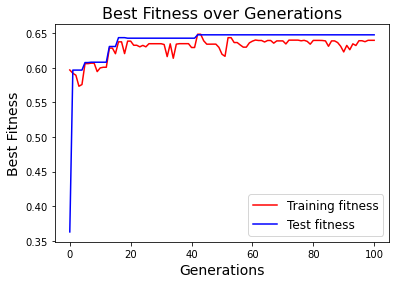

In [27]:
plt.plot(gen, max_fitness_values, color='red', label="Training fitness")
plt.plot(gen, fitness_test, color='blue', label="Test fitness")
plt.legend(fontsize=12)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Best Fitness', fontsize=14)
plt.title('Best Fitness over Generations', fontsize=16)
plt.yticks(np.arange(0.35, 0.67, 0.05))
plt.show()

**Average fitness plot**

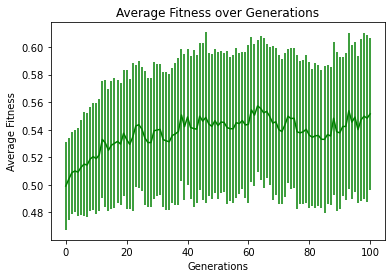

In [28]:
plt.xlabel('Generations')
plt.ylabel('Average Fitness')
plt.title('Average Fitness over Generations')
plt.errorbar(gen, mean_fitness_values, yerr=std_fitness_values,label="Best", color="Green")
plt.show()

**Genome length plots**

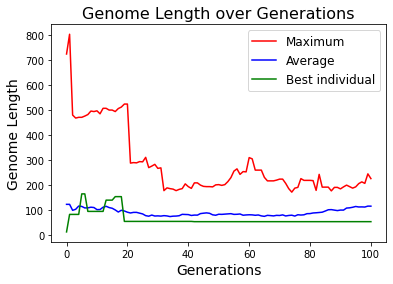

In [29]:
plt.plot(gen, max_length, color='red', label="Maximum")
plt.plot(gen, avg_length, color='blue', label="Average")
plt.plot(gen, best_ind_length, color='green', label="Best individual")
plt.legend(fontsize=12)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Genome Length', fontsize=14)
plt.title('Genome Length over Generations', fontsize=16)
plt.show()